In [1088]:
import pandas as ps
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk

nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from IPython.display import display_html
from itertools import chain,cycle
from bs4 import BeautifulSoup

stop_words = set(stopwords.words('english'))

import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
import geopandas as gpd
import branca.colormap

import warnings
warnings.filterwarnings('ignore')

# Get data from source
#LISTINGS_URL = "http://data.insideairbnb.com/sweden/stockholms-l%C3%A4n/stockholm/2021-02-25/data/listings.csv.gz"
#CALENDAR_URL = "http://data.insideairbnb.com/sweden/stockholms-l%C3%A4n/stockholm/2021-02-25/data/calendar.csv.gz"
#REVIEWS_URL = http://data.insideairbnb.com/sweden/stockholms-l%C3%A4n/stockholm/2021-02-25/data/reviews.csv.gz"

#df1 = ps.read_csv(LISTINGS_URL, compression='gzip')
#df2 = ps.read_csv(CALENDAR_URL, compression='gzip')
#df3 = ps.read_csv(REVIEWS_URL, compression='gzip')

# Getting data locally in development is faster
LISTINGS = 'listings.csv'
CALENDAR = 'calendar.csv'
REVIEWS = 'reviews.csv'

df1 = ps.read_csv(LISTINGS)
df2 = ps.read_csv(REVIEWS)
df3 = ps.read_csv(CALENDAR)

# Show all columns
ps.set_option('display.max_columns', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vilhelmi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1089]:
# Example of columns and values
print(df2.columns.tolist())
print(df3.columns.tolist())
print(df1.shape)
df1.head()

['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']
['listing_id', 'date', 'available', 'price', 'adjusted_price', 'minimum_nights', 'maximum_nights']
(2796, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,20083,https://www.airbnb.com/rooms/20083,20210225053501,2021-02-25,Unique in Södermalm SOFO Stockholm,Enjoy a stay in one of the most idyllic and co...,NaN,https://a0.muscache.com/pictures/102900/423071...,75962,https://www.airbnb.com/users/show/75962,Lovisa,2010-01-31,"Stockholm, Stockholm, Sweden","I'm 31, I work in the oldest now operating auc...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/75962/profile...,https://a0.muscache.com/im/users/75962/profile...,NaN,1,1,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Södermalms,NaN,59.30643,18.08785,Entire apartment,Entire home/apt,3,NaN,1 bath,1.0,1.0,"[""Smoke alarm"", ""Dryer"", ""Hair dryer"", ""Iron"",...",$995.00,4,28,4.0,4.0,28.0,28.0,4.0,28.0,NaN,t,29,59,89,364,2021-02-25,12,0,0,2010-03-28,2014-09-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,1,1,0,0,0.09
1,164448,https://www.airbnb.com/rooms/164448,20210225053501,2021-02-25,Double room in central Stockholm with Wi-Fi,I am renting out a nice double room on the top...,NaN,https://a0.muscache.com/pictures/1101571/13429...,784312,https://www.airbnb.com/users/show/784312,Li,2011-07-06,"Stockholm, Stockholm, Sweden","I am a recently retired lady, who has two room...",within a day,100%,100%,t,https://a0.muscache.com/im/users/784312/profil...,https://a0.muscache.com/im/users/784312/profil...,Södermalm,2,2,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Södermalms,NaN,59.31268,18.06258,Private room in apartment,Private room,2,NaN,1 shared bath,1.0,2.0,"[""Bed linens"", ""Washer"", ""Smoke alarm"", ""Dedic...",$643.00,3,300,3.0,3.0,300.0,300.0,3.0,300.0,NaN,t,29,59,89,179,2021-02-25,313,0,0,2011-07-30,2020-01-29,97.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,t,2,0,2,0,2.68
2,170651,https://www.airbnb.com/rooms/170651,20210225053501,2021-02-25,Petit Charm Rooftop next to heaven,<b>The space</b><br />Welcome to this beautifu...,NaN,https://a0.muscache.com/pictures/77469446/c3be...,814021,https://www.airbnb.com/users/show/814021,Marie,2011-07-13,"Stockholm, Stockholm, Sweden",Im a happy person living with my daughter Emma...,within a day,100%,0%,f,https://a0.muscache.com/im/pictures/user/137c6...,https://a0.muscache.com/im/pictures/user/137c6...,Södermalm,1,1,"['email', 'phone', 'reviews', 'offline_governm...",t,t,NaN,Södermalms,NaN,59.31568,18.03138,Entire apartment,Entire home/apt,4,NaN,1 bath,1.0,2.0,"[""Dryer"", ""Hair dryer"", ""Essentials"", ""Hot wat...","$1,387.00",4,30,4.0,4.0,30.0,30.0,4.0,30.0,NaN,t,18,40,62,297,2021-02-25,34,1,0,2011-08-14,2020-03-09,93.0,10.0,9.0,10.0,10.0,10.0,9.0,NaN,f,1,1,0,0,0.29
3,206221,https://www.airbnb.com/rooms/206221,20210225053501,2021-02-27,Doubleroom at Södermalm &trendySofo,<b>

In [1090]:
# Helper functions
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    
def convert_currency(val):
    """
    Convert the string number value to a float
     - Remove $
     - Remove commas
     - Convert to float type
    """
    new_val = val.replace(',','').replace('$', '')
    return float(new_val)

def preprocess_text(text):
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove unicode
    #text = (text.encode('ascii', 'ignore')).decode('utf-8')
    # Remove stopwords
    text_tokens = word_tokenize(text)
    words = set(nltk.corpus.words.words())
    filtered_words = [w for w in text_tokens if not w in stop_words]
    filtered_words = [w for w in filtered_words if w.lower() in words or not w.isalpha()]
    
    return " ".join(filtered_words)

In [1091]:
# Data wrangling of listings data

columns = [
    'id',
    'name',
    'description',
    'host_name',
    'host_since',
    #'host_location',
    'host_neighbourhood',
    'neighbourhood',
    'neighbourhood_cleansed',
    'instant_bookable',
    'latitude',
    'longitude',
    #'host_about',
    'host_response_time',
    'host_response_rate',
    'host_acceptance_rate',
    'host_is_superhost',
    'host_listings_count',
    'host_has_profile_pic',
    'host_identity_verified',
    'property_type',
    'room_type',
    'accommodates',
    'price',
    'number_of_reviews',
    'review_scores_rating',
    'review_scores_cleanliness',
    'reviews_per_month'
    
]

df1 = df1[columns]

# Replace id as the index
print(df1['id'].is_unique)
df1.set_index('id', inplace=True)
df1.head()

True


,name,description,host_name,host_since,host_neighbourhood,neighbourhood,neighbourhood_cleansed,instant_bookable,latitude,longitude,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,property_type,room_type,accommodates,price,number_of_reviews,review_scores_rating,review_scores_cleanliness,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,
20083,Unique in Södermalm SOFO Stockholm,Enjoy a stay in one of the most idyllic and co...,Lovisa,2010-01-31,NaN,NaN,Södermalms,f,59.30643,18.08785,NaN,NaN,NaN,f,1,t,t,Entire apartment,Entire home/apt,3,$995.00,12,100.0,10.0,0.09
164448,Double room in central Stockholm with Wi-Fi,I am renting out a nice double room on the top...,Li,2011-07-06,Södermalm,NaN,Södermalms,t,59.31268,18.06258,within a day,100%,100%,t,2,t,t,Private room in apartment,Private room,2,$643.00,313,97.0,10.0,2.68
170651,Petit Charm Rooftop next to heaven,<b>The space</b><br />Welcome to this beautifu...,Marie,2011-07-13,Södermalm,NaN,Södermalms,f,59.31568,18.03138,within a day,100%,0%,f,1,t,t,Entire apartment,Entire home/apt,4,"$1,387.00",34,93.0,9.0,0.29
206221,Doubleroom at Södermalm &trendySofo,<b>The space</b><br />The region is situated a...,Elisabeth,2011-08-26,NaN,NaN,Södermalms,f,59.31226,18.07942,NaN,NaN,0%,f,1,t,f,Shared room in apartment,Shared room,2,$669.00,79,98.0,10.0,0.70
220851,One room in appartement,Welcome!<br /><br /><b>The space</b><br />Welc...,Fredric,2011-02-27,Kungsholmen,"Stockholm, Stockholm County, Sweden",Kungsholmens,f,59.33376,18.03816,NaN,NaN,80%,f,2,t,t,Private room in apartment,Private room,1,$600.00,48,93.0,9.0,0.42


In [1092]:
# Need to convert some boolean values
d = {'t': True, 'f': False}
df1['host_is_superhost'] = df1['host_is_superhost'].map(d)
df1['host_has_profile_pic'] = df1['host_has_profile_pic'].map(d)
df1['host_identity_verified'] = df1['host_identity_verified'].map(d)
df1['instant_bookable'] = df1['instant_bookable'].map(d)
df1.head()

,name,description,host_name,host_since,host_neighbourhood,neighbourhood,neighbourhood_cleansed,instant_bookable,latitude,longitude,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,property_type,room_type,accommodates,price,number_of_reviews,review_scores_rating,review_scores_cleanliness,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,
20083,Unique in Södermalm SOFO Stockholm,Enjoy a stay in one of the most idyllic and co...,Lovisa,2010-01-31,NaN,NaN,Södermalms,False,59.30643,18.08785,NaN,NaN,NaN,False,1,True,True,Entire apartment,Entire home/apt,3,$995.00,12,100.0,10.0,0.09
164448,Double room in central Stockholm with Wi-Fi,I am renting out a nice double room on the top...,Li,2011-07-06,Södermalm,NaN,Södermalms,True,59.31268,18.06258,within a day,100%,100%,True,2,True,True,Private room in apartment,Private room,2,$643.00,313,97.0,10.0,2.68
170651,Petit Charm Rooftop next to heaven,<b>The space</b><br />Welcome to this beautifu...,Marie,2011-07-13,Södermalm,NaN,Södermalms,False,59.31568,18.03138,within a day,100%,0%,False,1,True,True,Entire apartment,Entire home/apt,4,"$1,387.00",34,93.0,9.0,0.29
206221,Doubleroom at Södermalm &trendySofo,<b>The space</b><br />The region is situated a...,Elisabeth,2011-08-26,NaN,NaN,Södermalms,False,59.31226,18.07942,NaN,NaN,0%,False,1,True,False,Shared room in apartment,Shared room,2,$669.00,79,98.0,10.0,0.70
220851,One room in appartement,Welcome!<br /><br /><b>The space</b><br />Welc...,Fredric,2011-02-27,Kungsholmen,"Stockholm, Stockholm County, Sweden",Kungsholmens,False,59.33376,18.03816,NaN,NaN,80%,False,2,True,True,Private room in apartment,Private room,1,$600.00,48,93.0,9.0,0.42


In [1093]:
# Check for invalid data types
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796 entries, 20083 to 48314089
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       2794 non-null   object 
 1   description                2688 non-null   object 
 2   host_name                  2796 non-null   object 
 3   host_since                 2796 non-null   object 
 4   host_neighbourhood         1841 non-null   object 
 5   neighbourhood              1509 non-null   object 
 6   neighbourhood_cleansed     2796 non-null   object 
 7   instant_bookable           2796 non-null   bool   
 8   latitude                   2796 non-null   float64
 9   longitude                  2796 non-null   float64
 10  host_response_time         1894 non-null   object 
 11  host_response_rate         1894 non-null   object 
 12  host_acceptance_rate       1986 non-null   object 
 13  host_is_superhost          2796 non-null

In [1094]:
# Convert to best possible types
df1 = df1.convert_dtypes()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796 entries, 20083 to 48314089
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       2794 non-null   string 
 1   description                2688 non-null   string 
 2   host_name                  2796 non-null   string 
 3   host_since                 2796 non-null   string 
 4   host_neighbourhood         1841 non-null   string 
 5   neighbourhood              1509 non-null   string 
 6   neighbourhood_cleansed     2796 non-null   string 
 7   instant_bookable           2796 non-null   boolean
 8   latitude                   2796 non-null   Float64
 9   longitude                  2796 non-null   Float64
 10  host_response_time         1894 non-null   string 
 11  host_response_rate         1894 non-null   string 
 12  host_acceptance_rate       1986 non-null   string 
 13  host_is_superhost          2796 non-null

In [1095]:
# Fix date types
df1['host_since'] = df1['host_since'].astype('datetime64')
df1['host_since'].head()

id
20083    2010-01-31
164448   2011-07-06
170651   2011-07-13
206221   2011-08-26
220851   2011-02-27
Name: host_since, dtype: datetime64[ns]

In [1096]:
# Price contains unwanted characters and has wrong type
df1['price'] = df1['price'].apply(convert_currency)
df1['price'].head()

id
20083      995.0
164448     643.0
170651    1387.0
206221     669.0
220851     600.0
Name: price, dtype: float64

In [1097]:
# The results so far
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796 entries, 20083 to 48314089
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       2794 non-null   string        
 1   description                2688 non-null   string        
 2   host_name                  2796 non-null   string        
 3   host_since                 2796 non-null   datetime64[ns]
 4   host_neighbourhood         1841 non-null   string        
 5   neighbourhood              1509 non-null   string        
 6   neighbourhood_cleansed     2796 non-null   string        
 7   instant_bookable           2796 non-null   boolean       
 8   latitude                   2796 non-null   Float64       
 9   longitude                  2796 non-null   Float64       
 10  host_response_time         1894 non-null   string        
 11  host_response_rate         1894 non-null   string        
 12

,name,description,host_name,host_since,host_neighbourhood,neighbourhood,neighbourhood_cleansed,instant_bookable,latitude,longitude,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,property_type,room_type,accommodates,price,number_of_reviews,review_scores_rating,review_scores_cleanliness,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,
20083,Unique in Södermalm SOFO Stockholm,Enjoy a stay in one of the most idyllic and co...,Lovisa,2010-01-31,<NA>,<NA>,Södermalms,False,59.30643,18.08785,<NA>,<NA>,<NA>,False,1,True,True,Entire apartment,Entire home/apt,3,995.0,12,100,10,0.09
164448,Double room in central Stockholm with Wi-Fi,I am renting out a nice double room on the top...,Li,2011-07-06,Södermalm,<NA>,Södermalms,True,59.31268,18.06258,within a day,100%,100%,True,2,True,True,Private room in apartment,Private room,2,643.0,313,97,10,2.68
170651,Petit Charm Rooftop next to heaven,<b>The space</b><br />Welcome to this beautifu...,Marie,2011-07-13,Södermalm,<NA>,Södermalms,False,59.31568,18.03138,within a day,100%,0%,False,1,True,True,Entire apartment,Entire home/apt,4,1387.0,34,93,9,0.29
206221,Doubleroom at Södermalm &trendySofo,<b>The space</b><br />The region is situated a...,Elisabeth,2011-08-26,<NA>,<NA>,Södermalms,False,59.31226,18.07942,<NA>,<NA>,0%,False,1,True,False,Shared room in apartment,Shared room,2,669.0,79,98,10,0.7
220851,One room in appartement,Welcome!<br /><br /><b>The space</b><br />Welc...,Fredric,2011-02-27,Kungsholmen,"Stockholm, Stockholm County, Sweden",Kungsholmens,False,59.33376,18.03816,<NA>,<NA>,80%,False,2,True,True,Private room in apartment,Private room,1,600.0,48,93,9,0.42


In [1098]:
# Property_type and room_type could be categories
print(df1['property_type'].unique())
print(df1['room_type'].unique())

<StringArray>
[                  'Entire apartment',          'Private room in apartment',
           'Shared room in apartment',              'Private room in house',
                  'Entire guesthouse',          'Private room in townhouse',
                       'Entire house',                        'Entire loft',
               'Private room in loft',              'Private room in villa',
                   'Entire townhouse', 'Private room in serviced apartment',
                 'Entire condominium',                       'Entire villa',
  'Private room in bed and breakfast',          'Entire serviced apartment',
        'Private room in condominium',                 'Entire guest suite',
                       'Entire cabin',              'Shared room in hostel',
        'Private room in guest suite',                      'Room in hotel',
                          'Camper/RV',               'Shared room in house',
                          'Farm stay',                     'Ro

In [1099]:
df1['property_type'] = df1['property_type'].astype('category')
df1['room_type'] = df1['room_type'].astype('category')
df1.info()
df1['property_type'].head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2796 entries, 20083 to 48314089
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       2794 non-null   string        
 1   description                2688 non-null   string        
 2   host_name                  2796 non-null   string        
 3   host_since                 2796 non-null   datetime64[ns]
 4   host_neighbourhood         1841 non-null   string        
 5   neighbourhood              1509 non-null   string        
 6   neighbourhood_cleansed     2796 non-null   string        
 7   instant_bookable           2796 non-null   boolean       
 8   latitude                   2796 non-null   Float64       
 9   longitude                  2796 non-null   Float64       
 10  host_response_time         1894 non-null   string        
 11  host_response_rate         1894 non-null   string        
 12

id
20083              Entire apartment
164448    Private room in apartment
170651             Entire apartment
206221     Shared room in apartment
220851    Private room in apartment
Name: property_type, dtype: category
Categories (43, object): ['Boat', 'Camper/RV', 'Casa particular', 'Entire apartment', ..., 'Shared room in house', 'Shared room in serviced apartment', 'Shared room in tiny house', 'Tiny house']

In [1100]:
# Turn rates into floats

df1['host_acceptance_rate'] = df1['host_acceptance_rate'].str.replace("[%, ]", "").astype("float")/100
df1['host_response_rate'] = df1['host_response_rate'].str.replace("[%, ]", "").astype("float")/100
df1['review_scores_rating'] = df1['review_scores_rating'].div(100)

In [1101]:
# Let's remove empty values
df1 = df1.dropna(axis=0)
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 278311 to 47741278
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   name                       641 non-null    string        
 1   description                641 non-null    string        
 2   host_name                  641 non-null    string        
 3   host_since                 641 non-null    datetime64[ns]
 4   host_neighbourhood         641 non-null    string        
 5   neighbourhood              641 non-null    string        
 6   neighbourhood_cleansed     641 non-null    string        
 7   instant_bookable           641 non-null    boolean       
 8   latitude                   641 non-null    Float64       
 9   longitude                  641 non-null    Float64       
 10  host_response_time         641 non-null    string        
 11  host_response_rate         641 non-null    float64       
 12

,name,description,host_name,host_since,host_neighbourhood,neighbourhood,neighbourhood_cleansed,instant_bookable,latitude,longitude,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,property_type,room_type,accommodates,price,number_of_reviews,review_scores_rating,review_scores_cleanliness,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,
278311,Entire apt (some weeks this summer),When we will be away in the summer it's possib...,Linnéa,2011-11-29,Farsta,"Farsta, Stockholms län, Sweden",Farsta,False,59.24534,18.08729,within a day,1.0,0.25,False,1,True,True,Entire apartment,Entire home/apt,6,360.0,53,0.93,9,0.47
299154,Cosy apartment central at Sodermalm,Very centrally located small apartment at Slus...,Daniel,2011-12-28,Södermalm,"Stockholm, Stockholm County, Sweden",Södermalms,True,59.31846,18.07042,within an hour,1.0,1.00,True,1,True,True,Entire apartment,Entire home/apt,4,1056.0,527,0.92,9,5.62
748847,Gorgeous apartment in 1885 building,Gorgeous 3-room apartment in 1885 building. 72...,Heath,2012-10-21,Södermalm,"Stockholm, Stockholm County, Sweden",Södermalms,False,59.31612,18.07526,within a few hours,1.0,1.00,True,1,True,False,Entire apartment,Entire home/apt,2,1295.0,18,0.96,10,0.18
838442,City Backpackers - 6 Bed Apartment with Sauna,Our 19th century apartment is part of our Host...,Joakim,2012-12-11,Norrmalm,"Stockholm, Stockholm County, Sweden",Norrmalms,True,59.33593,18.05542,within an hour,1.0,1.00,False,3,True,False,Entire apartment,Entire home/apt,6,1667.0,44,0.92,9,0.73
875505,Super centric attic at Stureplan,Top notch apartment on top floor in the middle...,Freja,2012-10-25,Norrmalm,"Stockholm, Stockholm County, Sweden",Norrmalms,False,59.33171,18.0735,within a few hours,1.0,0.63,False,1,True,True,Entire apartment,Entire home/apt,2,1142.0,54,0.95,10,0.58


In [1102]:
# Description column has HTML tags and unwanted characters
#print(df1['description'].values[2])
#print('\n')

#df1['description'] = df1['description'].str.replace('<[^<]+?>', '', regex=True)

#df1['description'] = df1['description'].apply(preprocess_text)

#df1['description'] = df1['description'].str.replace('</b>', '. ')
#df1['description'] = df1['description'].str.replace('<br />', '')
#df1['description'] = df1['description'].str.replace('<b>', '')
#df1['description'] = df1['description'].str.replace('<br /', '')

#print(df1['description'].values[2])

Minimumn price: 99.0 maximum price: 6506.0 



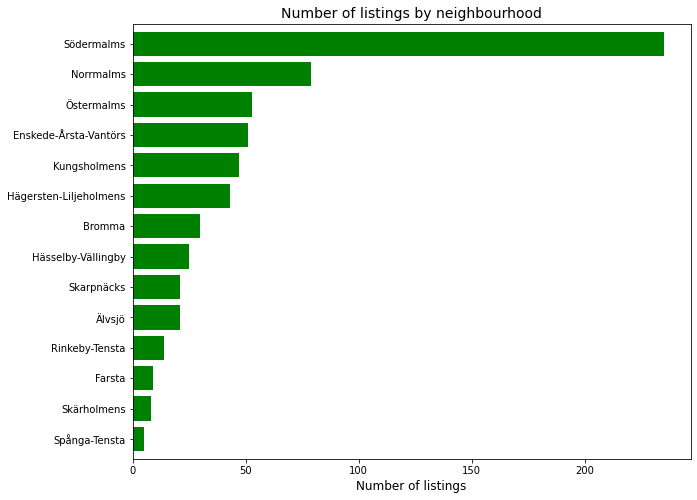

In [1112]:
price_data = df1[['price', 'neighbourhood_cleansed', 'latitude', 'longitude']]
min_price = price_data['price'].min()
max_price = price_data['price'].max()

print("Minimumn price:", min_price, "maximum price:", max_price, "\n")

listings = df1['neighbourhood_cleansed'].value_counts().sort_values(ascending=True).rename("listings_amount")
listings.plot.barh(figsize=(10,8), color = 'green', width= 0.8)
plt.title('Number of listings by neighbourhood', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.show()

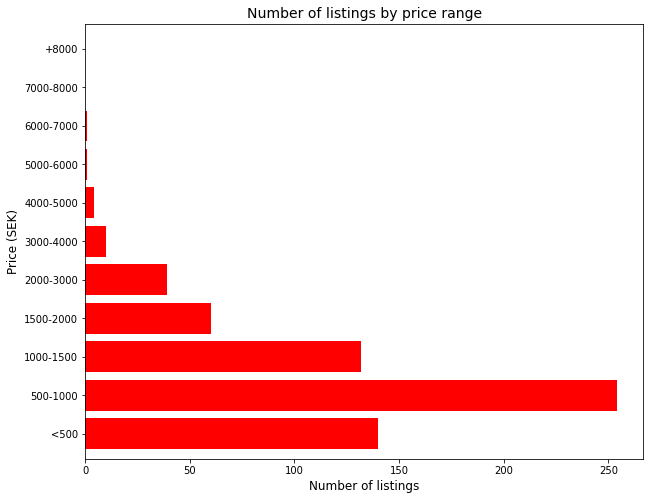

In [1104]:
# Good to remember that prices are in SEK

bins = [0, 500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000, 8000, np.inf]
names = ['<500', '500-1000','1000-1500', '1500-2000', '2000-3000', '3000-4000', '4000-5000', '5000-6000', '6000-7000', '7000-8000', '+8000']

price_data['PriceRange'] = ps.cut(price_data['price'], bins, labels=names)
prices = price_data['PriceRange'].value_counts()
prices = prices.reindex(names)

prices.plot.barh(figsize=(10,8), color ='r', width= 0.8)
plt.title('Number of listings by price range', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.ylabel('Price (SEK)', fontsize = 12)
plt.show()

Minimumn price: 99.0 maximum price: 6506.0 



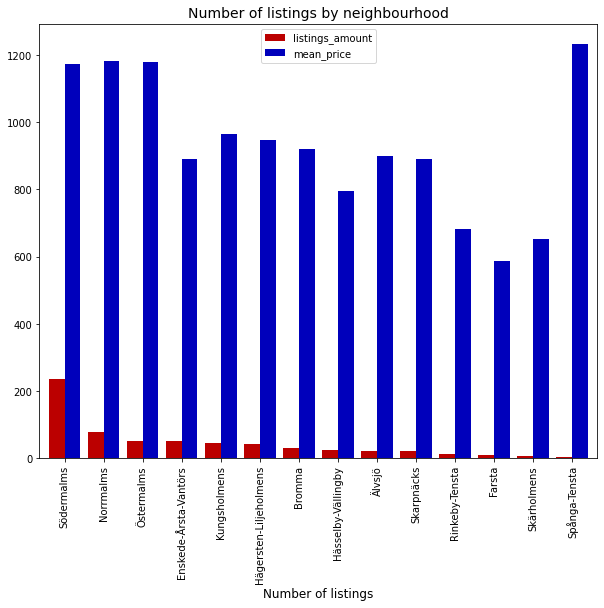

In [1105]:
price_data = df1[['price', 'neighbourhood_cleansed', 'latitude', 'longitude']]

# What are the maximum and minimum prices?
min_price = price_data['price'].min()
max_price = price_data['price'].max()

print("Minimumn price:", min_price, "maximum price:", max_price, "\n")

# Calculate mean prices in each neighbourhood
mean_prices = price_data.groupby('neighbourhood_cleansed')['price'].mean().astype('int64')

# Now let's plot mean prices and neighbourhood listings together

frequencies = df1['neighbourhood_cleansed'].value_counts().rename("listings_amount")
test = ps.DataFrame(frequencies, columns = ['listings_amount'])
test['mean_price'] = mean_prices
test.plot.bar(figsize=(10,8), y=['listings_amount', 'mean_price'], color = ['#BB0000', '#0000BB'], width= 0.8)

plt.title('Number of listings by neighbourhood', fontsize=14)
plt.xlabel('Number of listings', fontsize = 12)
plt.show()

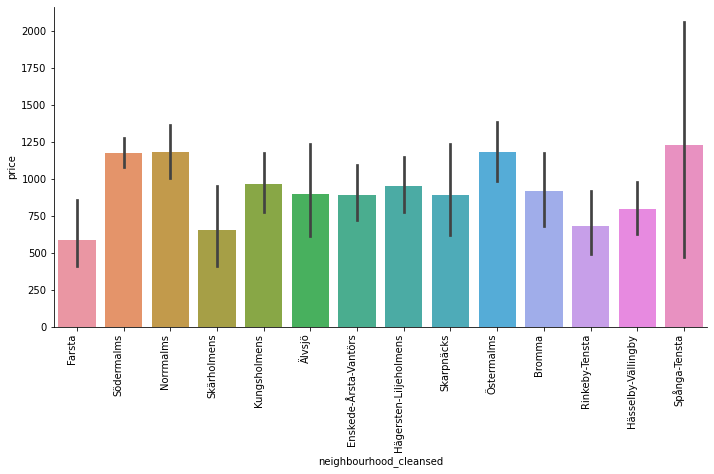

In [1106]:
# Investigate location affect on price
import seaborn as sns 
location_price=sns.catplot(x='neighbourhood_cleansed', y='price', kind ='bar', data= df1, aspect=2)
location_price.set_xticklabels(rotation=90, horizontalalignment='right')


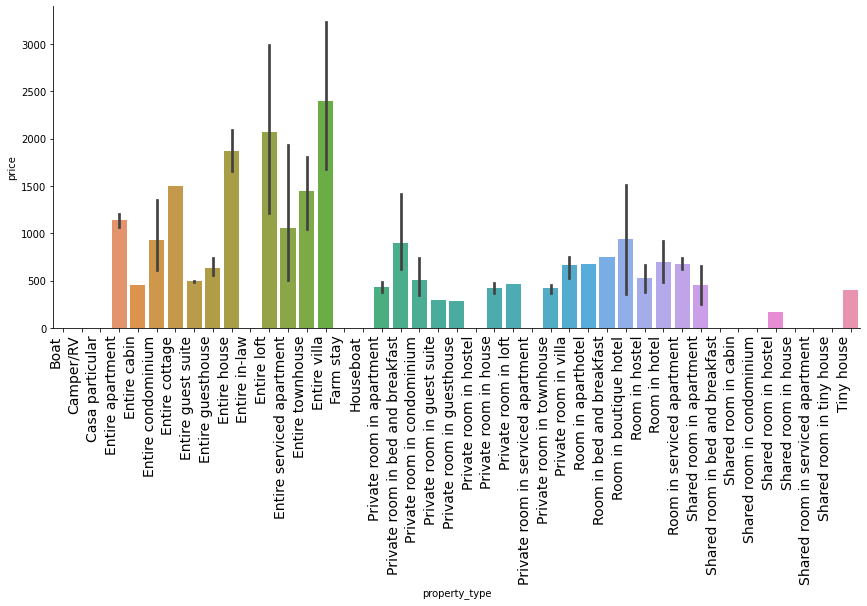

In [1116]:
# Investigate affect of property type on price
location_price=sns.catplot(x='property_type', y='price', kind ='bar', data= df1, aspect=2.5)
location_price.set_xticklabels(rotation=90, horizontalalignment='right', fontsize = 14)


In [1108]:
# https://towardsdatascience.com/airbnb-part-b-python-interactive-map-natural-language-processing-48d472f14da3

STOCKHOLM_COORDINATES = [59.329, 18.069]
TILEs = ["http://tile.stamen.com/terrain/{z}/{x}/{y}.jpg"]

latitudes = df1['latitude'].tolist()
longitudes=df1['longitude'].tolist()
locations = list(zip(latitudes, longitudes))

sw = df1[['latitude', 'longitude']].min().values.tolist()
ne = df1[['latitude', 'longitude']].max().values.tolist()

bounds = [sw, ne]

# Create map
map1 = folium.Map(location=STOCKHOLM_COORDINATES, zoom_start=12.5, maxBounds=bounds, min_zoom=11)

# Add fastmarkers
FastMarkerCluster(data=locations, name='Listing markers').add_to(map1)

# Add heat map
heat_df = df1[['latitude', 'longitude']]
heat_df = heat_df.dropna(axis=0, subset=['latitude','longitude'])
heat_data = [[row['latitude'],row['longitude']] for index, row in heat_df.iterrows()]
HeatMap(heat_data, name='Listings heat map').add_to(map1)

# Add legend
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 100)
colormap = colormap.to_step(6, round_method='log10')
colormap.caption = 'Listings'
colormap.add_to(map1)

# Add toggle control
folium.map.LayerControl('topleft', collapsed= False).add_to(map1)

# Display map
map1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 278311 to 47741278
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   host_response_rate                     641 non-null    float64
 1   host_acceptance_rate                   641 non-null    float64
 2   price                                  641 non-null    float64
 3   number_of_reviews                      641 non-null    Int64  
 4   review_scores_rating                   641 non-null    Float64
 5   host_response_rate                     641 non-null    float64
 6   host_acceptance_rate                   641 non-null    float64
 7   price                                  641 non-null    float64
 8   number_of_reviews                      641 non-null    Int64  
 9   review_scores_rating                   641 non-null    Float64
 10  host_response_time_a few days or more  641 non-null    uint8  
 

Text(0.5, 1.0, 'Feature correlation matrix')

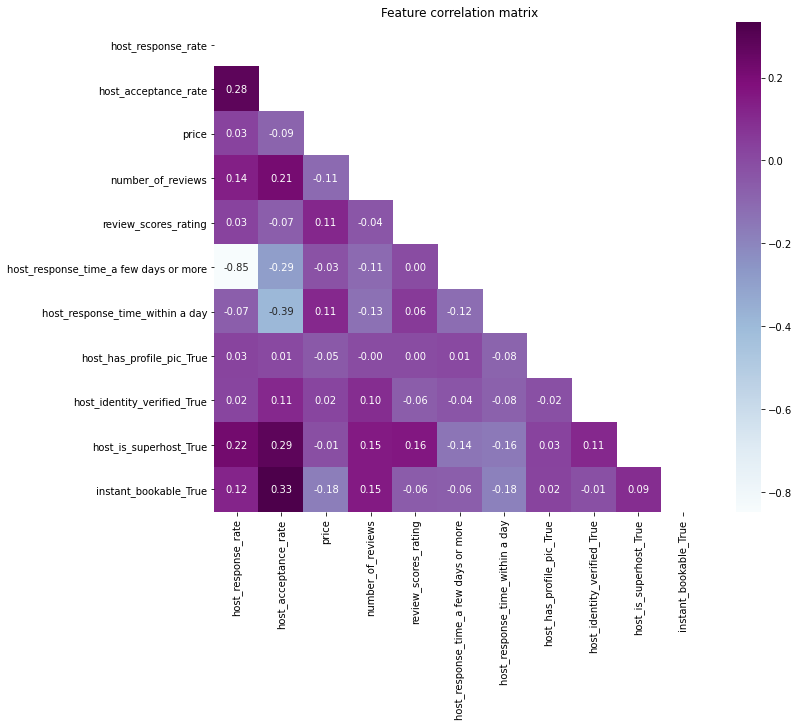

In [1109]:
# Investigate correlations between features

reg_data = df1
dummy_s= ps.get_dummies(reg_data, columns=['host_response_time',
                        'host_has_profile_pic', 
                        'host_identity_verified', 
                        'host_is_superhost', 
                        'instant_bookable'])


reg_data_merged= ps.concat([reg_data,dummy_s], axis=1)
reg_data_merged.drop(reg_data_merged.columns.difference(['host_response_rate',
                        'host_acceptance_rate', 
                        'price',
                        'host_response_time_a few days or more',
                        'host_response_time_within a day',
                        'host_has_profile_pic_True',
                        'host_identity_verified_True',    
                        'host_is_superhost_True',
                        'instant_bookable_True',
                        'number_of_reviews',
                        'review_scores_rating']), 1, inplace=True)

print(reg_data_merged.info())

# Remove duplicate values
reg_data_merged = reg_data_merged.loc[:,~reg_data_merged.columns.duplicated()]
reg_data_merged.head()

# This part is straight from an example

# Get correlation between features
corr = reg_data_merged.corr()

# Return boolean matrix in order to create triangle-shape
mask = np.triu(np.ones_like(corr, dtype=np.bool))

plt.rcParams['figure.figsize'] = [11, 9]
sns.heatmap(corr, mask=mask, annot = True, fmt='.2f', cmap="BuPu")
plt.title(label= "Feature correlation matrix", fontdict=None, loc='center', pad=None)

In [1110]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import  r2_score, mean_squared_error 
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor


# Let's use ensemble-methods that combine the use of different classifiers.
# Käytetään ensemble-metodeja, jotka yhdistävät useita eri luokittelijoita
# In averaging methods, the driving principle is to build several estimators independently and then to average their predictions.
# On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced

# Choose a decision-tree approach. Described in the documentation:
# The sklearn.ensemble module includes two averaging algorithms based on randomized decision trees: the RandomForest algorithm and the Extra-Trees method. Both algorithms are perturb-and-combine techniques [B1998] specifically designed for trees.
# This means a diverse set of classifiers is created by introducing randomness in the classifier construction.
# The prediction of the ensemble is given as the averaged prediction of the individual classifiers.

data = reg_data_merged.copy()

# Let's look at how different features affect this variable
TARGET_COLUMN = 'review_scores_rating'

# Our X-data is all but the target
X = data.drop([TARGET_COLUMN], axis=1)

# And Y is the target
Y = data[TARGET_COLUMN]

# Split into random train and test subsets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =0.25, random_state=42)

# Standardize features
sc= StandardScaler()
X_train= sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# Use ExtraTreesRegressor
regressor = ExtraTreesRegressor(n_estimators=300, criterion='mse', random_state=42, n_jobs=-1)
regressor.fit(X_train, Y_train.squeeze())

Y_train_preds = regressor.predict(X_train)
Y_test_preds = regressor.predict(X_test)
print('Extra Tree Accuracies')
print('Extra Trees MSE train: %.3f, test: %.3f' % (mean_squared_error(Y_train, Y_train_preds), mean_squared_error(Y_test, Y_test_preds)))
print('Extra Trees R^2 train: %.3f, test: %.3f' % (r2_score(Y_train, Y_train_preds),r2_score(Y_test, Y_test_preds)))




Extra Tree Accuracies
Extra Trees MSE train: 0.000, test: 0.007
Extra Trees R^2 train: 1.000, test: -0.852


Text(0.5, 1.0, 'Feature importances analysis for reviews')

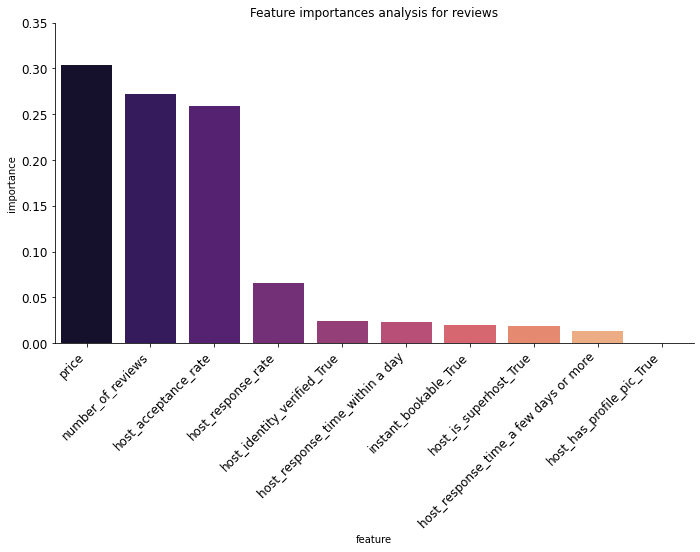

In [1111]:
# What is the most meaningful feature in terms of review score rating?

importances = regressor.feature_importances_
feat_names = X.columns
tree_result = ps.DataFrame({'feature': feat_names, 'importance': importances})
tree_result_sort = tree_result.sort_values(by='importance',ascending=False)[:10]
chart = sns.catplot(x='feature', y='importance', kind='bar', data=tree_result_sort, palette="magma", aspect=2)
chart.set_xticklabels(rotation=45, horizontalalignment='right', fontsize = 12)
chart.set_yticklabels(fontsize=12)
plt.title(label= "Feature importances analysis for reviews", fontdict=None, loc='center', pad=None)